# 2.1.1: Feature importance


Now we explore how the different predictor datasets and their constituent features affected model performance.


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.conf.conf import get_config
from src.conf.environment import log

cfg = get_config()

## Feature importance


Investigate the importance of the different datasets for each trait and then across trait sets.


In [21]:
# Load model performance results for later filtering of FI
all_results = pd.read_parquet("results/all_results.parquet").query(
    "resolution.str.contains('km') and transform == 'power'"
)

# Load feature importance results across all models
all_fi = pd.read_parquet("results/all_fi.parquet").query(
    "resolution.str.contains('km')"
)
all_fi

,pft,resolution,trait_id,trait_set,automl,model_arch,run_id,feature,agg,importance,stddev,p_value,n,p99_high,p99_low,dataset
165,Shrub_Tree_Grass,1km,X11_mean,splot_gbif,True,GBM,20241111_143848,ETH_GlobalCanopyHeightSD_2020_v1,mean,0.003838,0.003541,4.787300e-02,10.0,0.007477,0.000198,canopy_height
166,Shrub_Tree_Grass,1km,X138_mean,splot,True,GBM,20241122_230826,ETH_GlobalCanopyHeightSD_2020_v1,mean,0.000071,0.000413,4.558885e-01,10.0,0.000496,-0.000353,canopy_height
167,Shrub_Tree_Grass,1km,X3112_mean,splot,True,GBM,20241130_131639,ETH_GlobalCanopyHeightSD_2020_v1,mean,0.000580,0.000423,9.426285e-02,10.0,0.001015,0.000146,canopy_height
168,Shrub_Tree_Grass,1km,X145_mean,splot,True,GBM,20241123_230735,ETH_GlobalCanopyHeightSD_2020_v1,mean,-0.000207,0.000526,3.187613e-01,10.0,0.000333,-0.000747,canopy_height
169,Shrub_Tree_Grass,1km,X282_mean,splot,True,GBM,20241128_084354,ETH_GlobalCanopyHeightSD_2020_v1,mean,0.000955,0.000581,8.874007e-03,10.0,0.001552,0.000358,canopy_height
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519538,Shrub_Tree_Grass,222km,X144_mean,splot_gbif,True,GBM,20250123_211509,wc2.1_30s_bio_4,std,0.013964,0.002040,4.433019e-01,0.0,0.015328,0.012800,worldclim
11519539,Shrub_Tree_Grass,222km,X144_mean,splot_gbif,True,GBM,20250123_211509,wc2.1_30s_bio_7,mean,0.000209,0.002762,4.848745e-01,10.0,0.003047,-0.002630,worldclim
11519540,Shrub_Tree_Grass,222km,X144_mean,splot_gbif,True,GBM,20250123_211509,wc2.1_30s_bio_7,std,0.004405,0.001442,4.776924e-01,0.0,0.005200,0.004019,worldclim
11519541,Shrub_Tree_Grass,222km,X144_mean,splot_gbif,True,GBM,20250123_211509,worldclim,mean,0.064371,0.010981,3.716241e-07,10.0,0.075655,0.053086,worldclim_full


To get a general overview of how much the datasets contribute to model performance, we can plot the mean performance of each dataset across all traits for each trait set.


### Grouped feature permutation importance across all traits and trait sets

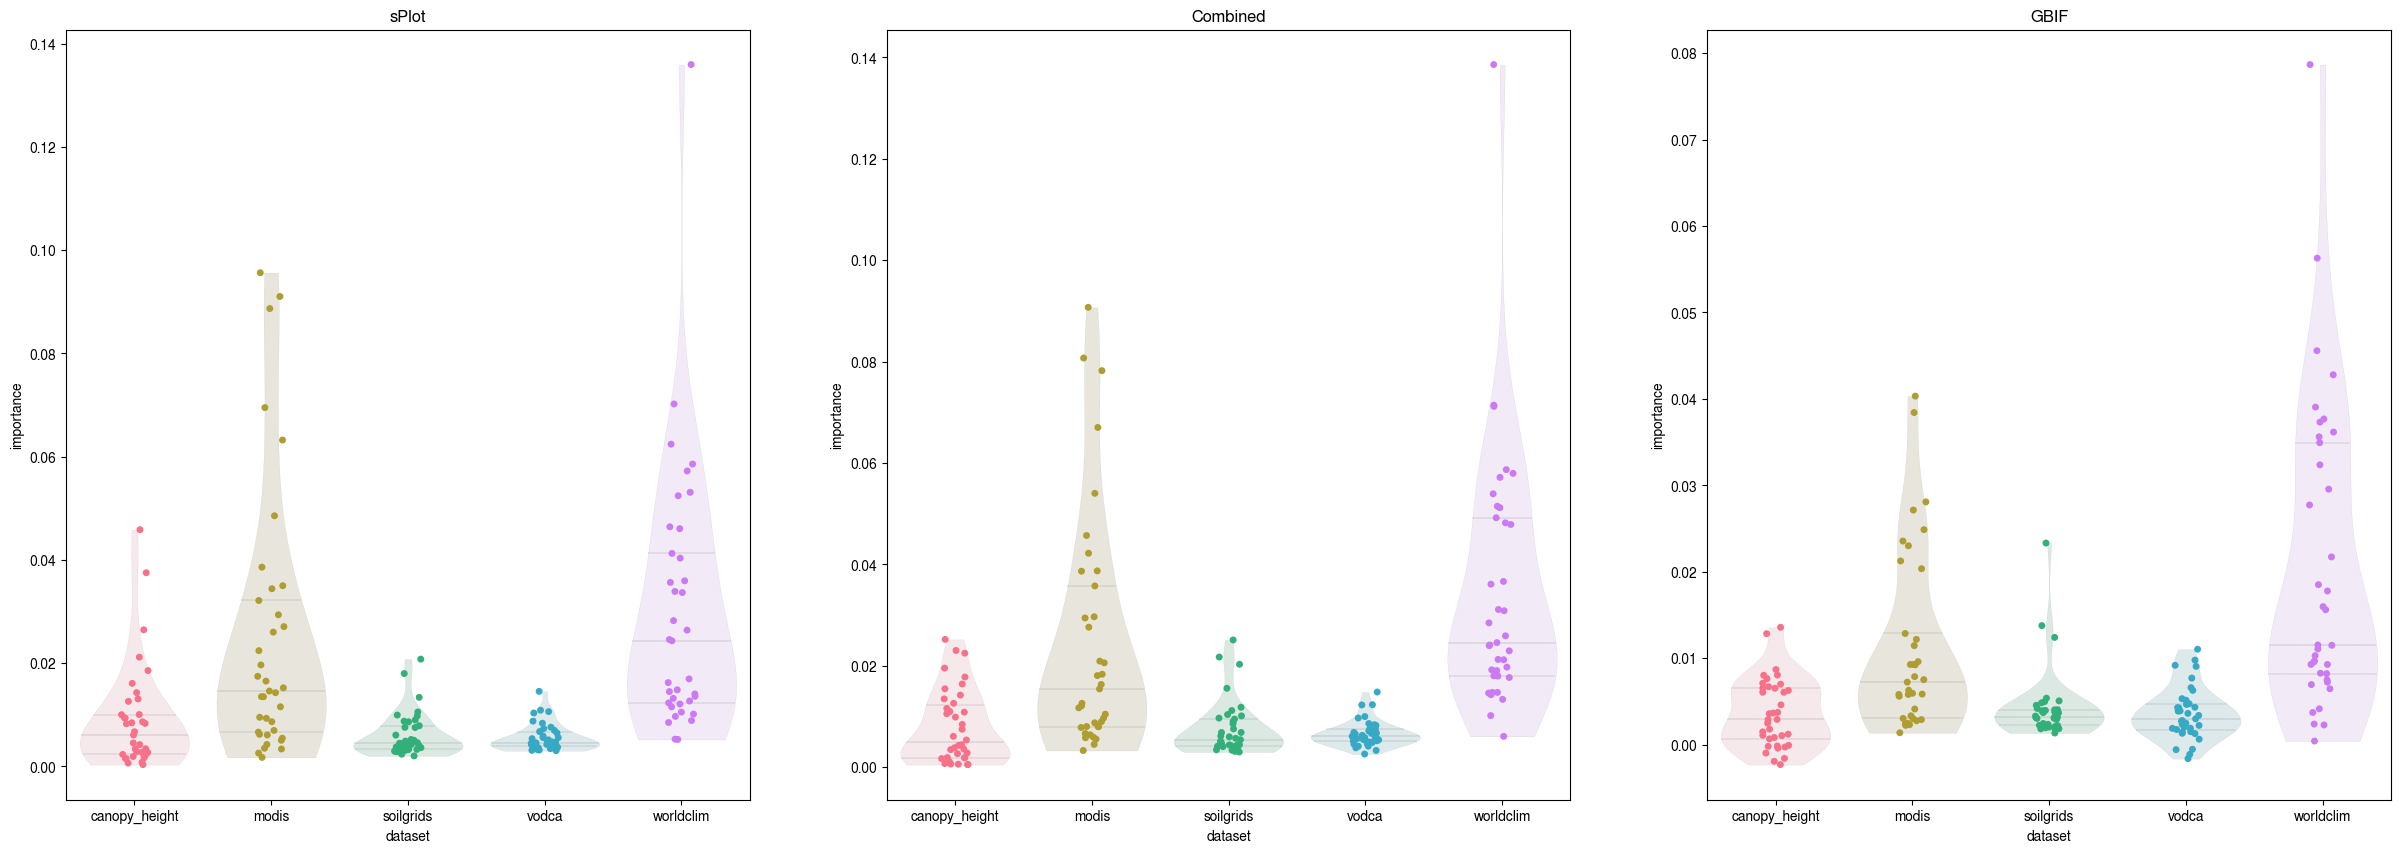

In [101]:
ft_data = all_fi.query("resolution == '1km' and agg == 'mean'")[
    ["trait_id", "dataset", "importance", "trait_set"]
].query("not dataset.str.contains('_full')")

# Group by trait_id and then calculate the mean importance for each dataset
ft_data = ft_data.groupby(["trait_id", "dataset", "trait_set"]).max().reset_index()

# log transform importance (first shift up into positive values)
# data["importance"] = data.importance + (abs(data.importance.min()) + 1e-6)
# data["importance"] = np.log(data.importance + (abs(data.importance.min()) + 1))
trait_sets = ["splot", "splot_gbif", "gbif"]
trait_set_names = ["sPlot", "Combined", "GBIF"]
nrows = 1
ncols = len(trait_sets)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))
for i, (trait_set, ax) in enumerate(zip(trait_sets, axs.flatten())):
    ts_data = ft_data.query(f"trait_set == '{trait_set}'")

    sns.violinplot(
        data=ts_data,
        x="dataset",
        y="importance",
        ax=ax,
        hue="dataset",
        palette="husl",
        saturation=0.5,
        fill=True,
        alpha=0.2,
        inner="quartiles",
        # whis=(5, 95)
        # log_scale=True
        linewidth=0.2,
        cut=0,
    )

    sns.stripplot(
        data=ts_data,
        x="dataset",
        y="importance",
        ax=ax,
        hue="dataset",
        palette="husl",
        # saturation=0.5,
        # dodge=True,
        # alpha=0.3
        # log_scale=True
    )

    # ax.set_yscale("symlog")
    ax.set_title(trait_set_names[i])

# Set all y scales to the same range
# for ax in axs.flatten():
#     ax.set_ylim(-0.4, 1e3)

### Dataset permutation importance across all traits and trait sets

Mean importances for COMB
              importance       
                    mean    std
dataset                        
MODIS              0.083  0.037
WorldClim          0.051  0.026
SoilGrids          0.042  0.019
Canopy Height      0.008  0.007
VODCA              0.006  0.003


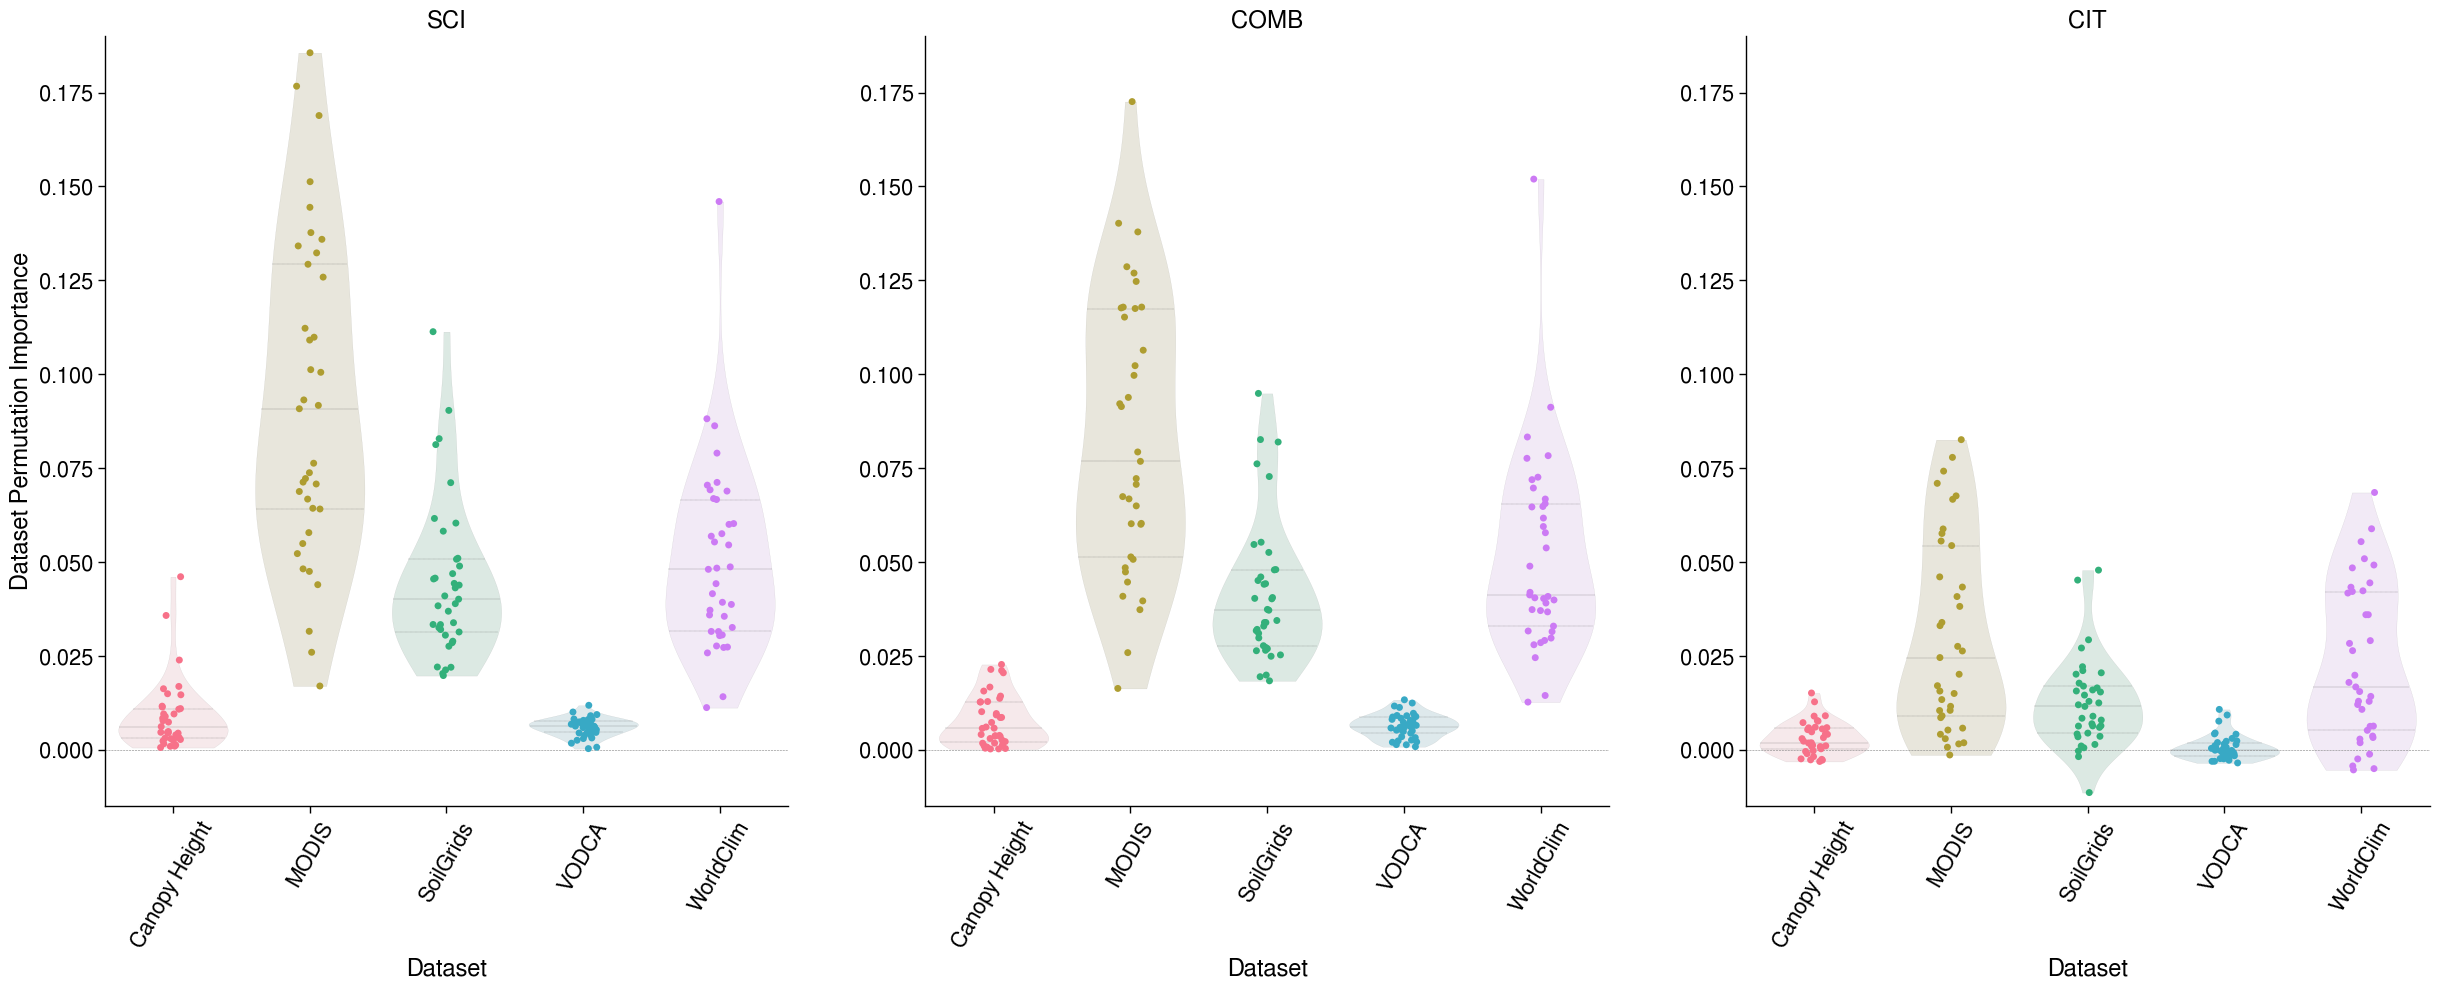

In [88]:
from src.utils.plotting_utils import set_font

SAVE = True

ds_data = all_fi.query("resolution == '1km' and agg == 'mean'")[
    ["trait_id", "dataset", "importance", "trait_set"]
].query("dataset.str.contains('_full')")

dataset_mapping = {
    "canopy_height_full": "Canopy Height",
    "modis_full": "MODIS",
    "soilgrids_full": "SoilGrids",
    "vodca_full": "VODCA",
    "worldclim_full": "WorldClim",
}

ds_data["dataset"] = ds_data.dataset.map(dataset_mapping)

# Group by trait_id and then calculate the mean importance for each dataset
ds_data = ds_data.groupby(["trait_id", "dataset", "trait_set"]).mean().reset_index()

# log transform importance (first shift up into positive values)
# data["importance"] = data.importance + (abs(data.importance.min()) + 1e-6)
# data["importance"] = np.log(data.importance + (abs(data.importance.min()) + 1))
trait_sets = ["splot", "splot_gbif", "gbif"]
trait_set_names = ["SCI", "COMB", "CIT"]
nrows = 1
ncols = len(trait_sets)

set_font("FreeSans")

with sns.plotting_context("paper", font_scale=1.8):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))
    for i, (trait_set, ax) in enumerate(zip(trait_sets, axs.flatten())):
        ts_data = ds_data.query(f"trait_set == '{trait_set}'")

        sns.violinplot(
            data=ts_data,
            x="dataset",
            y="importance",
            ax=ax,
            hue="dataset",
            palette="husl",
            saturation=0.5,
            fill=True,
            alpha=0.2,
            inner="quartiles",
            # whis=(5, 95)
            # log_scale=True
            linewidth=0.2,
            cut=0,
        )

        sns.stripplot(
            data=ts_data,
            x="dataset",
            y="importance",
            ax=ax,
            hue="dataset",
            palette="husl",
            # saturation=0.5,
            # dodge=True,
            # alpha=0.3
        )

        # ax.set_yscale("symlog")
        ax.set_title(trait_set_names[i])
        ax.set_ylabel("Dataset Permutation Importance")
        ax.set_xlabel("Dataset")

        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.4)

        for tick in ax.get_xticklabels():
            tick.set_rotation(60)

        if i != 0:
            ax.set_ylabel("")
    # Set all y scales to the same range
    for ax in axs.flatten():
        ax.set_ylim(-0.015, 0.19)

    sns.despine()

if SAVE:
    plt.savefig(
        "results/figures/dataset_importance_violin.png", bbox_inches="tight", dpi=300
    )

# Print mean dataset importances for COMB
print("Mean importances for COMB")
print(
    ds_data.query("trait_set == 'splot_gbif'")[["dataset", "importance"]]
    .groupby("dataset")
    .agg(["mean", "std"])
    .sort_values(("importance", "mean"), ascending=False)
    .round(3)
)

In [99]:
data.query("trait_set == 'splot_gbif'").drop(columns=["trait_set"]).groupby("trait_id").mean()

TypeError: agg function failed [how->mean,dtype->object]

In [104]:
from src.utils.plotting_utils import add_trait_name


ft_data.pipe(add_trait_name)

,trait_id,dataset,trait_set,importance,trait_name
0,X1080_mean,canopy_height,gbif,0.006513,SRL
1,X1080_mean,canopy_height,splot,0.014283,SRL
2,X1080_mean,canopy_height,splot_gbif,0.014222,SRL
3,X1080_mean,modis,gbif,0.005833,SRL
4,X1080_mean,modis,splot,0.014590,SRL
...,...,...,...,...,...
551,X95_mean,vodca,splot,0.004188,Seed germination rate
552,X95_mean,vodca,splot_gbif,0.005624,Seed germination rate
553,X95_mean,worldclim,gbif,0.015950,Seed germination rate
554,X95_mean,worldclim,splot,0.058555,Seed germination rate


In [115]:
heatmap_data.query(f"trait_set == '{trait_set}'").pivot_table(index="trait_name", columns="dataset", values="importance")


dataset,canopy_height,modis,soilgrids,vodca,worldclim
trait_name,,,,,
Chromosome cDNA content,0.003602,0.006389,0.011828,0.005846,0.036639
Chromosome number,0.000522,0.005811,0.003935,0.003309,0.006080
Conduit element length,0.002823,0.010460,0.006857,0.004630,0.014753
Dispersal unit length,0.008449,0.006646,0.003927,0.003820,0.019741
LDMC,0.001882,0.029673,0.005995,0.008612,0.017973
Leaf C,0.005369,0.015441,0.006845,0.004868,0.024096
Leaf C/N ratio,0.000544,0.080702,0.011175,0.006860,0.019195
Leaf N (area),0.001862,0.042199,0.015568,0.006072,0.014627
Leaf N (mass),0.000945,0.067005,0.004053,0.012332,0.019056


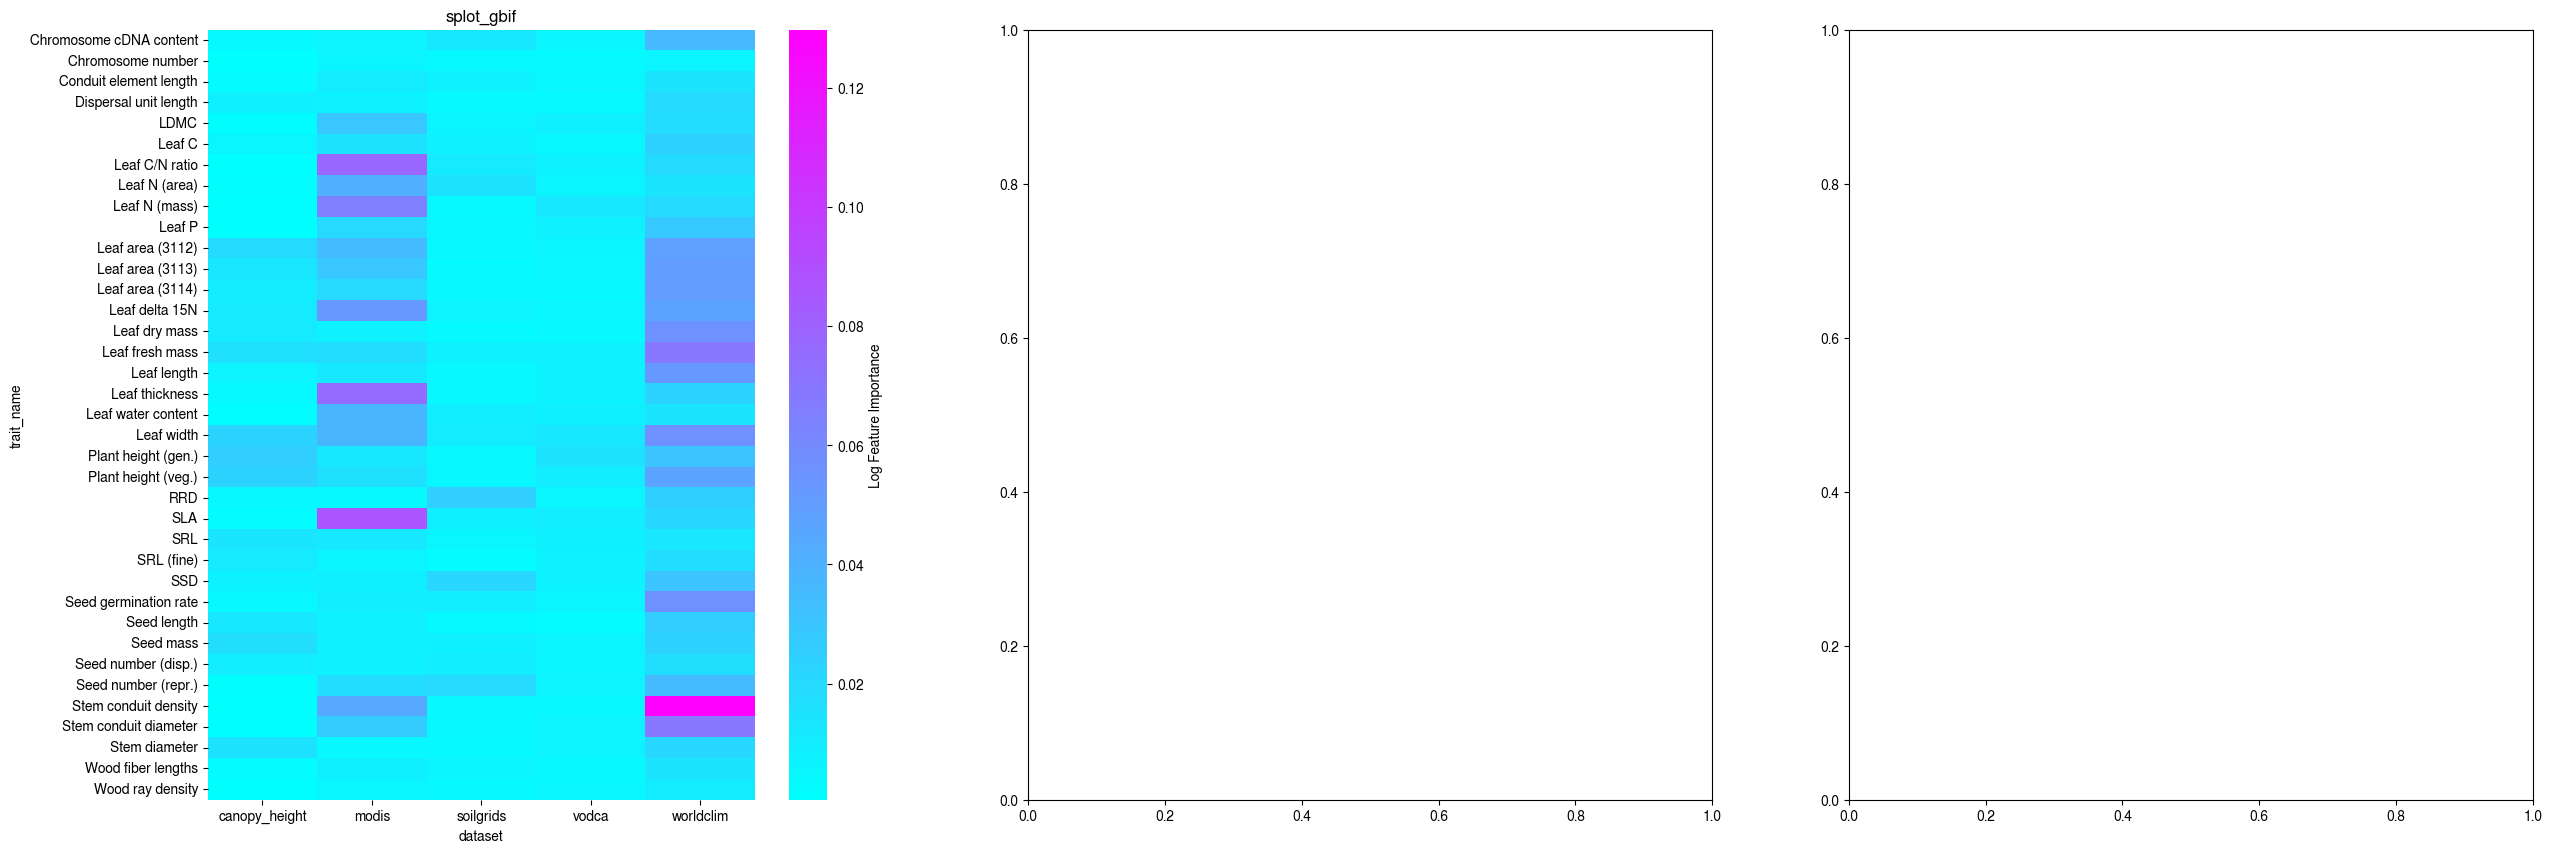

In [ ]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))

heatmap_data = (
    ft_data.query("trait_set == 'splot_gbif'")
    .pipe(add_trait_name)
    .drop(columns=["trait_id"])
)
for trait_set, ax in zip(heatmap_data.trait_set.unique(), axs.flatten()):
    # Plot a heatmap of the feature importance for each trait_id
    ts_hm_data = heatmap_data.query(f"trait_set == '{trait_set}'").pivot_table(
        index="trait_name", columns="dataset", values="importance"
    )
    sns.heatmap(
        # np.log1p(
        #     ts_hm_data
        # ),
        ts_hm_data,
        ax=ax,
        cmap="cool",
        cbar_kws={"label": "Log Feature Importance"},
    )

    ax.set_title(trait_set)


Now lets filter out models with an $R^2$ of less than $0.2$.


Text(0.5, 0.98, 'Mean feature importance by dataset\n(models with R2 >= 0.2)')

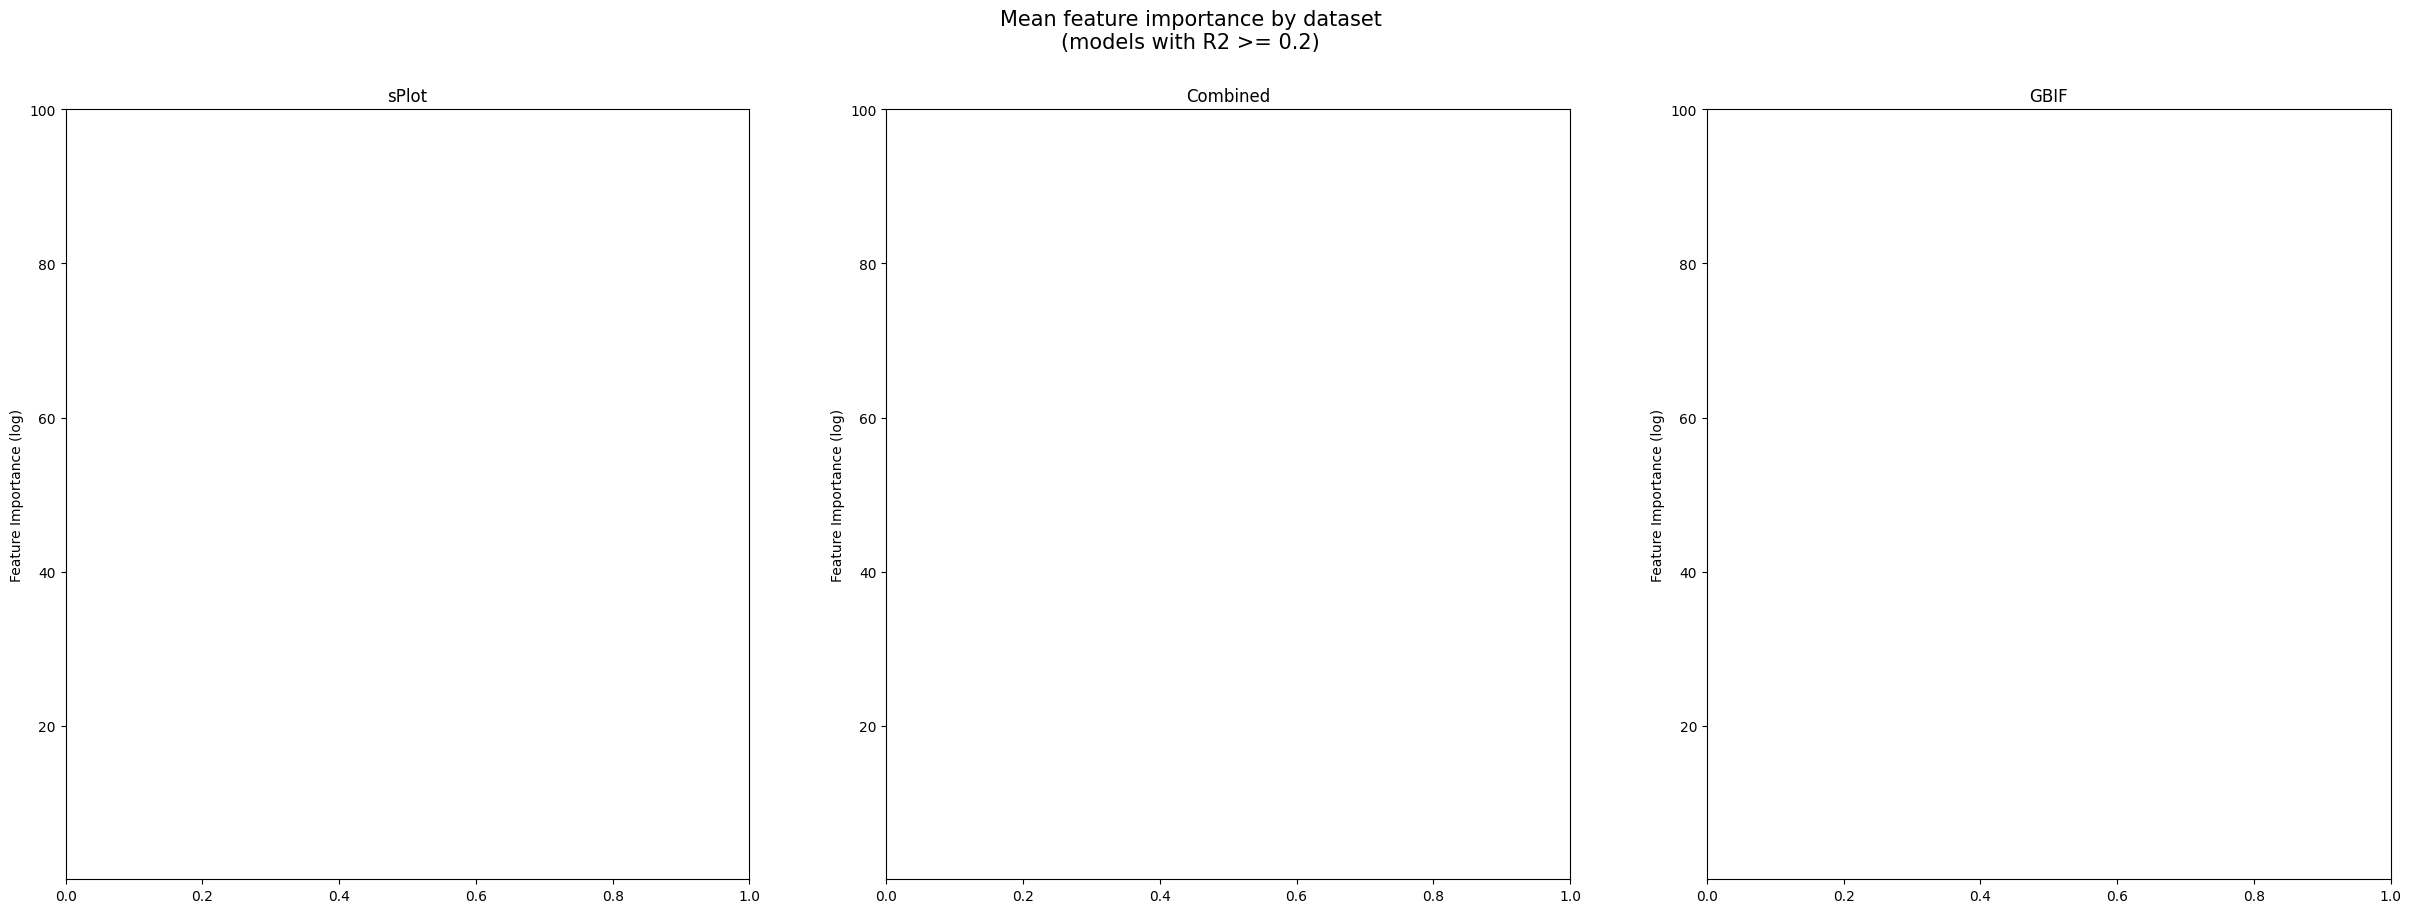

In [ ]:
res_001_best = all_results.query("resolution == '001' and r2 >= 0.2")[
    ["trait_id", "trait_set"]
]

# Get only feature importance rows where the trait_id and the trait_set matches the best performing models
data = all_fi.query("resolution == '001' and agg == 'mean'").merge(
    res_001_best, on=["trait_id", "trait_set"]
)[["trait_id", "dataset", "importance", "trait_set"]]

data = (
    data.groupby(["trait_id", "dataset", "trait_set"])
    # .agg(lambda x: x.quantile(0.95, interpolation="nearest"))
    .mean()
    .reset_index()
)
data["importance"] = data.importance + (abs(data.importance.min()) + 1e-6)
# data["importance"] = np.log(data.importance + (abs(data.importance.min()) + 1))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))
for i, (trait_set, ax) in enumerate(zip(trait_sets, axs.flatten())):
    ts_data = data.query(f"trait_set == '{trait_set}'")

    sns.violinplot(
        data=ts_data,
        x="dataset",
        y="importance",
        ax=ax,
        hue="dataset",
        palette="husl",
        saturation=0.5,
        fill=True,
        alpha=0.2,
        inner="quartiles",
        # whis=(5, 95)
        # log_scale=True
        linewidth=0.2,
        cut=0,
    )

    sns.stripplot(
        data=ts_data,
        x="dataset",
        y="importance",
        ax=ax,
        hue="dataset",
        palette="husl",
        # saturation=0.5,
        # dodge=True,
        # alpha=0.3
    )

    # ax.set_yscale("symlog")
    ax.set_title(trait_set_names[i])
    ax.set_ylabel("Feature Importance (log)")

# Set all y scales to the same range
for ax in axs.flatten():
    ax.set_ylim(1e-1, 1e2)

fig.suptitle(
    "Mean feature importance by dataset\n(models with R2 >= 0.2)",
    fontsize=15,
)

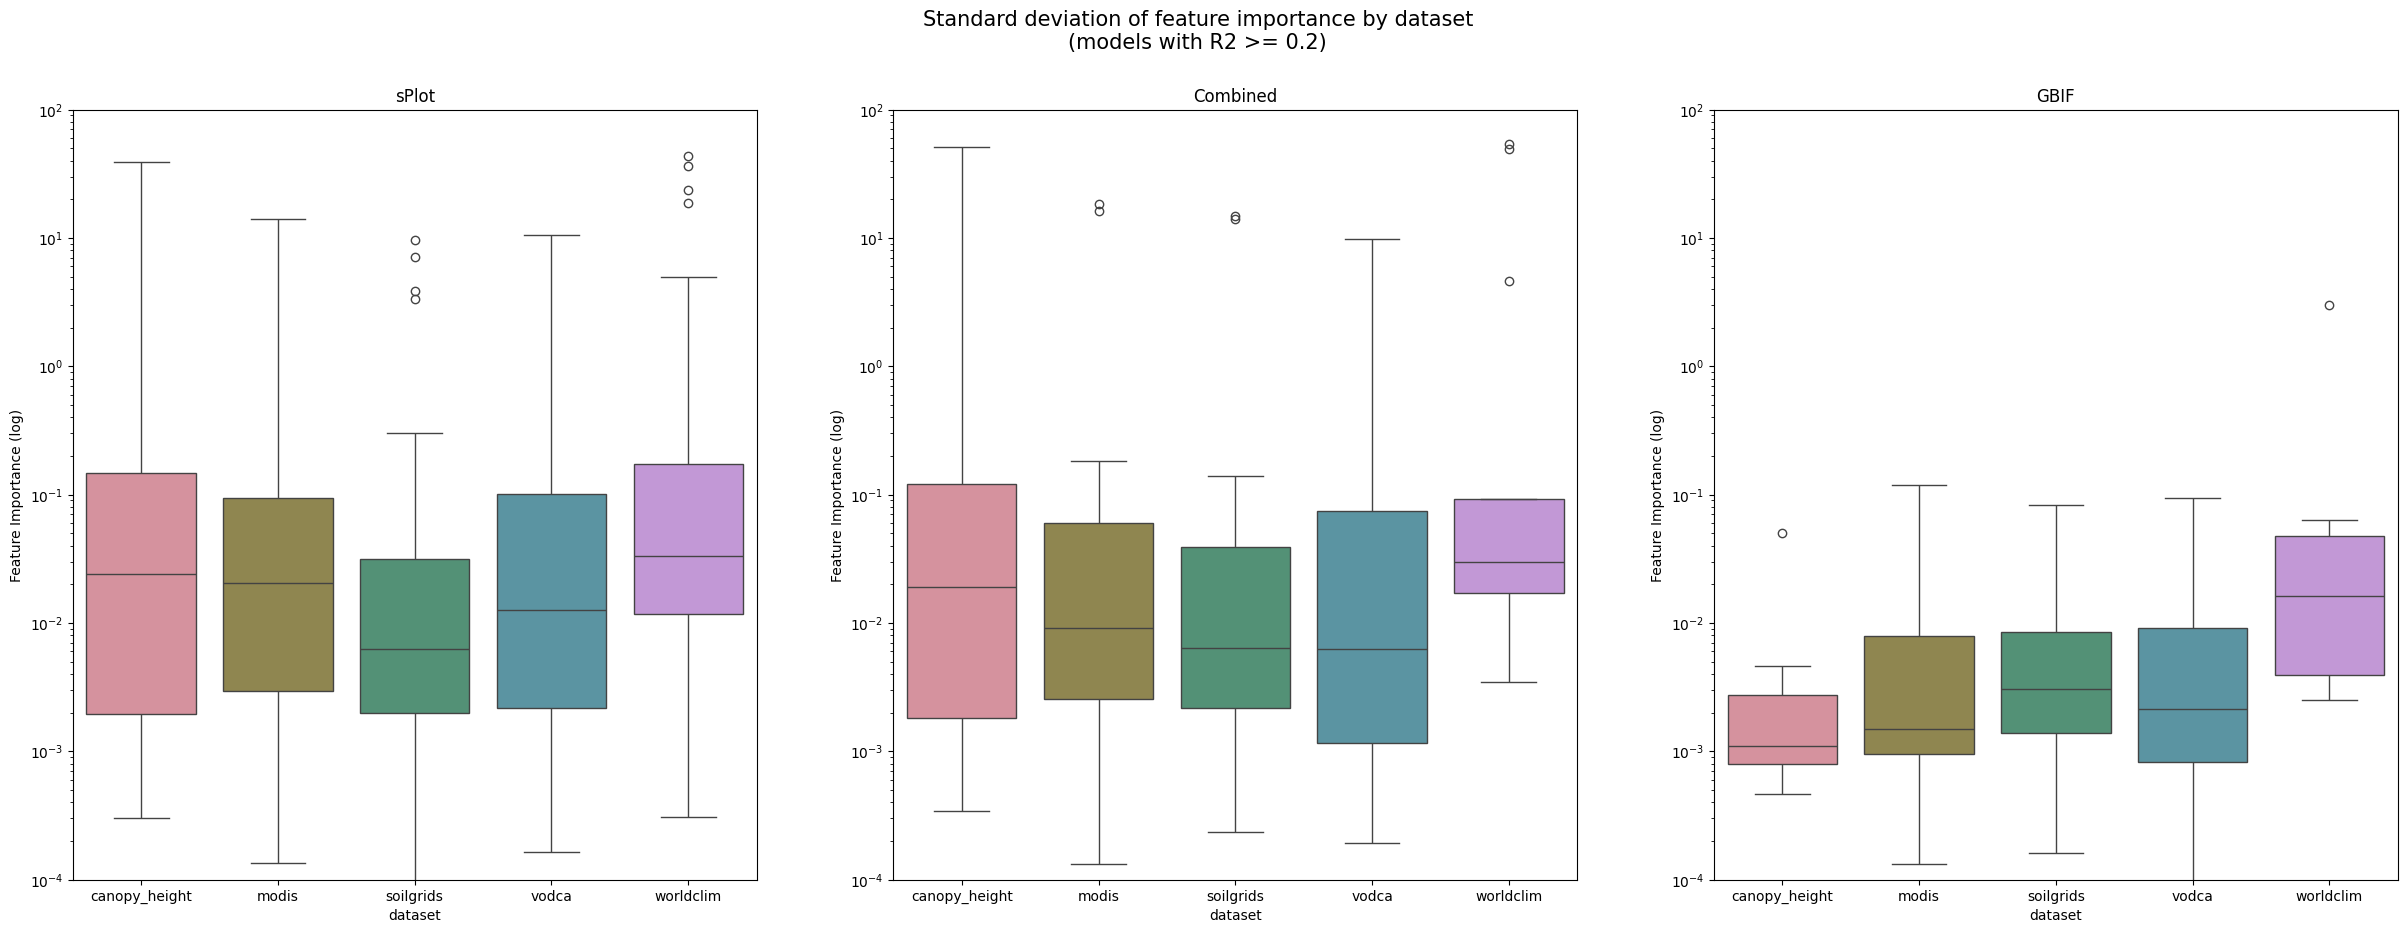

In [262]:
res_001_best = all_results.query("resolution == '001' and r2 >= 0.2")[
    ["trait_id", "trait_set"]
]

# Get only feature importance rows where the trait_id and the trait_set matches the best performing models
data = all_fi.query("resolution == '001' and agg == 'mean'").merge(
    res_001_best, on=["trait_id", "trait_set"]
)[["trait_id", "dataset", "importance", "trait_set"]]

data = (
    data.groupby(["trait_id", "dataset", "trait_set"])
    # .agg(lambda x: x.quantile(0.95, interpolation="nearest"))
    .std()
    .reset_index()
)
# data["importance"] = data.importance + (abs(data.importance.min()) + 1e-6)
# data["importance"] = np.log(data.importance + (abs(data.importance.min()) + 1))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))
for i, (trait_set, ax) in enumerate(zip(trait_sets, axs.flatten())):
    ts_data = data.query(f"trait_set == '{trait_set}'")

    sns.boxplot(
        data=ts_data,
        x="dataset",
        y="importance",
        ax=ax,
        hue="dataset",
        palette="husl",
        saturation=0.5,
        fill=True,
        # whis=(5, 95)
        log_scale=True,
    )

    # ax.set_yscale("symlog")
    ax.set_title(trait_set_names[i])
    ax.set_ylabel("Feature Importance (log)")

# Set all y scales to the same range
for ax in axs.flatten():
    ax.set_ylim(1e-4, 1e2)

fig.suptitle(
    "Standard deviation of feature importance by dataset\n(models with R2 >= 0.2)",
    fontsize=15,
);

Let's visualize the significance of each dataset per trait.


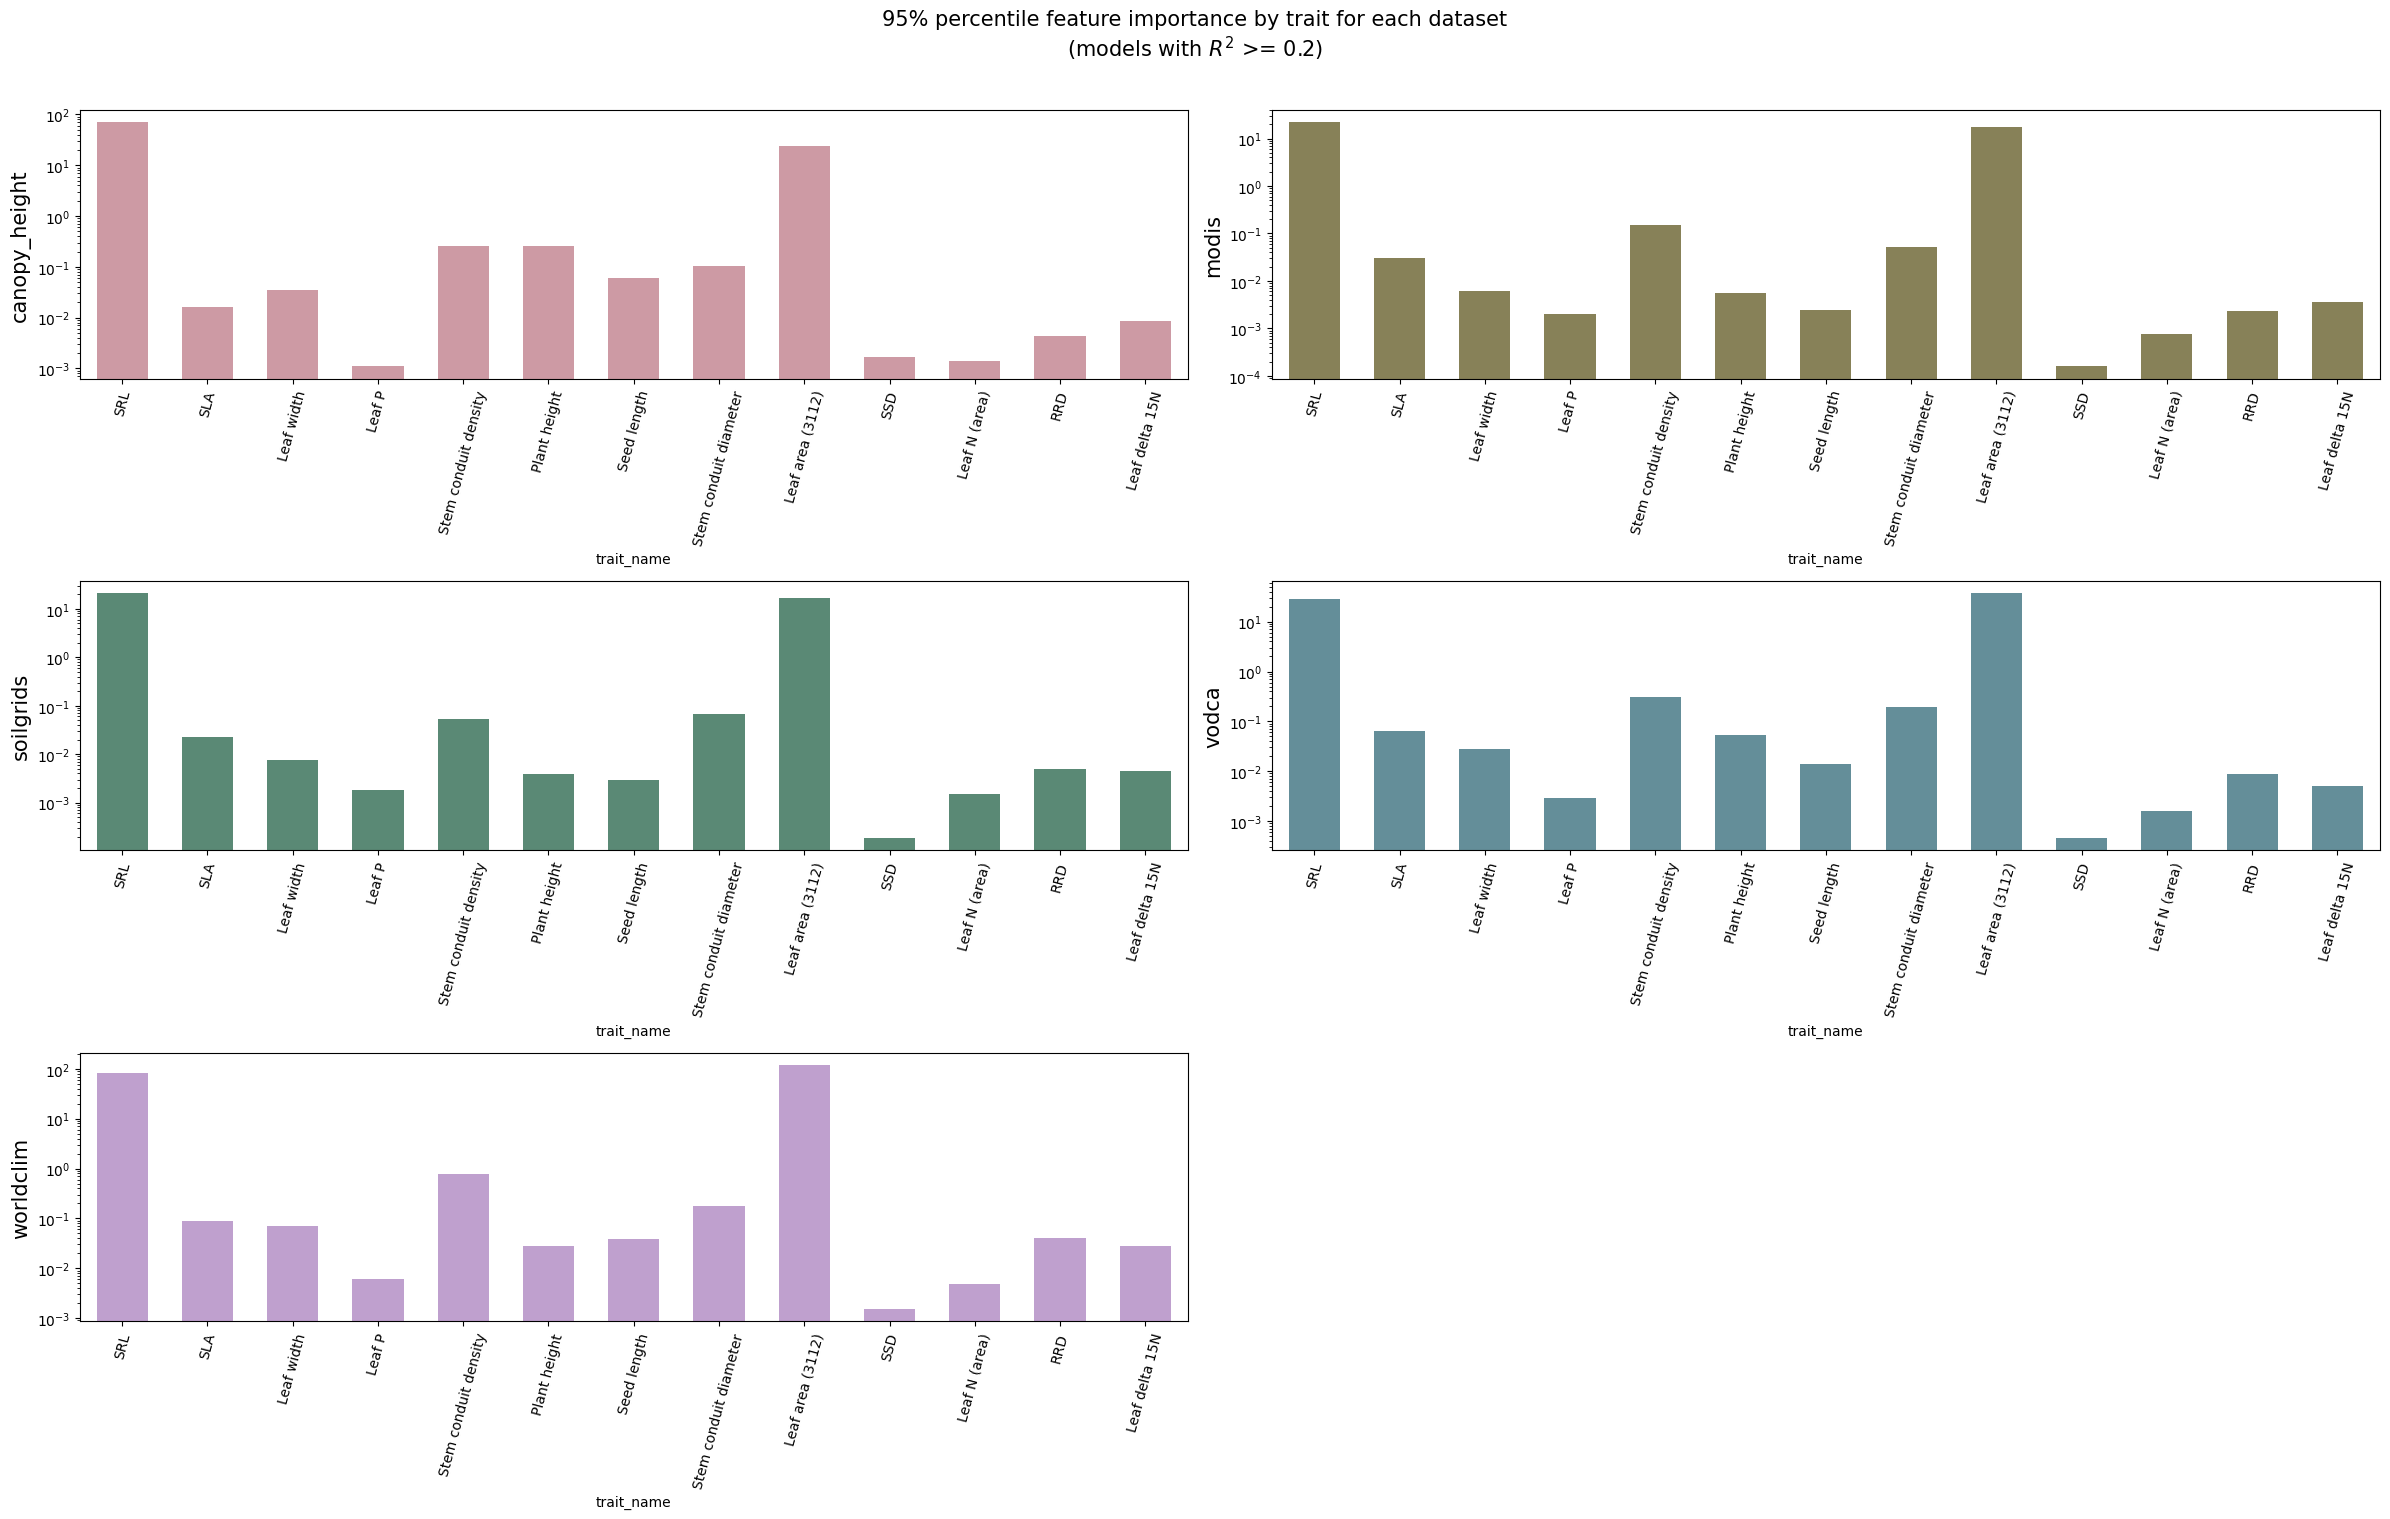

In [ ]:
from matplotlib.pyplot import tight_layout
from src.utils.trait_utils import get_trait_name_from_id


res_001_best = all_results.query("resolution == '001' and r2 >= 0.2")[
    ["trait_id", "trait_set"]
]

# Get only feature importance rows where the trait_id and the trait_set matches the best performing models
data = all_fi.query("resolution == '001' and agg == 'mean'").merge(
    res_001_best, on=["trait_id", "trait_set"]
)[["trait_id", "dataset", "importance", "trait_set"]]

data = (
    data.groupby(["trait_id", "dataset", "trait_set"])
    .agg(lambda x: x.quantile(0.95, interpolation="nearest"))
    .reset_index()
)

trait_id_to_name = {
    trait_id: get_trait_name_from_id(trait_id)[0] for trait_id in data.trait_id.unique()
}

# Replace each trait_id with its corresponding trait name using the dictionary
data["trait_name"] = data.trait_id.map(trait_id_to_name)

nrows = 3
ncols = 2
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(12 * ncols, 5 * nrows), tight_layout=True
)

datasets = data.dataset.unique()
palette = sns.color_palette("husl", len(datasets), desat=0.5)
# Plot a bar chart for each dataset such the y axis is the importance and the x axis is the trait_id
for i, (dataset, ax) in enumerate(zip(datasets, axs.flatten())):
    ds_data = data.query(f"dataset == '{dataset}' and trait_set == 'splot_gbif'")

    # each plot a different color
    sns.barplot(
        data=ds_data,
        x="trait_name",
        y="importance",
        ax=ax,
        color=palette[i],
        # palette="husl"
        # saturation=0.5,
        width=0.6,
    )
    ax.set_ylabel(f"{dataset}", fontsize=15)

    ax.set_yscale("log")
    # rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(75)

fig.suptitle(
    f"95% percentile feature importance by trait for each dataset\n(models with $R^2$ >= 0.2)",
    fontsize=15,
    y=1.01,
)
# remove empty plots
for ax in axs.flatten():
    if len(ax.patches) == 0:
        fig.delaxes(ax)

In [5]:
data

,trait_id,dataset,trait_set,importance
0,X1080_mean,canopy_height,splot,71.547413
1,X1080_mean,canopy_height,splot_gbif,70.750759
2,X1080_mean,modis,splot,38.529560
3,X1080_mean,modis,splot_gbif,44.010015
4,X1080_mean,soilgrids,splot,36.827312
...,...,...,...,...
225,X95_mean,canopy_height,splot,0.096824
226,X95_mean,modis,splot,0.034558
227,X95_mean,soilgrids,splot,0.033147
228,X95_mean,vodca,splot,0.086149


In [ ]:
from src.utils.trait_utils import get_trait_name_from_id


data = (
    all_fi.query("resolution == '001' and agg == 'mean'")[
        ["trait_id", "dataset", "importance", "trait_set"]
    ]
    .groupby(["trait_id", "dataset", "trait_set"])
    .mean()
    .reset_index()
)

# Replace each trait_id with its corresponding trait name (from get_trait_name_from_id)
# Create a dictionary to map trait_id to trait_name
trait_id_to_name = {
    trait_id: get_trait_name_from_id(trait_id)[0] for trait_id in data.trait_id.unique()
}

# Replace each trait_id with its corresponding trait name using the dictionary
data["trait_name"] = data.trait_id.map(trait_id_to_name)

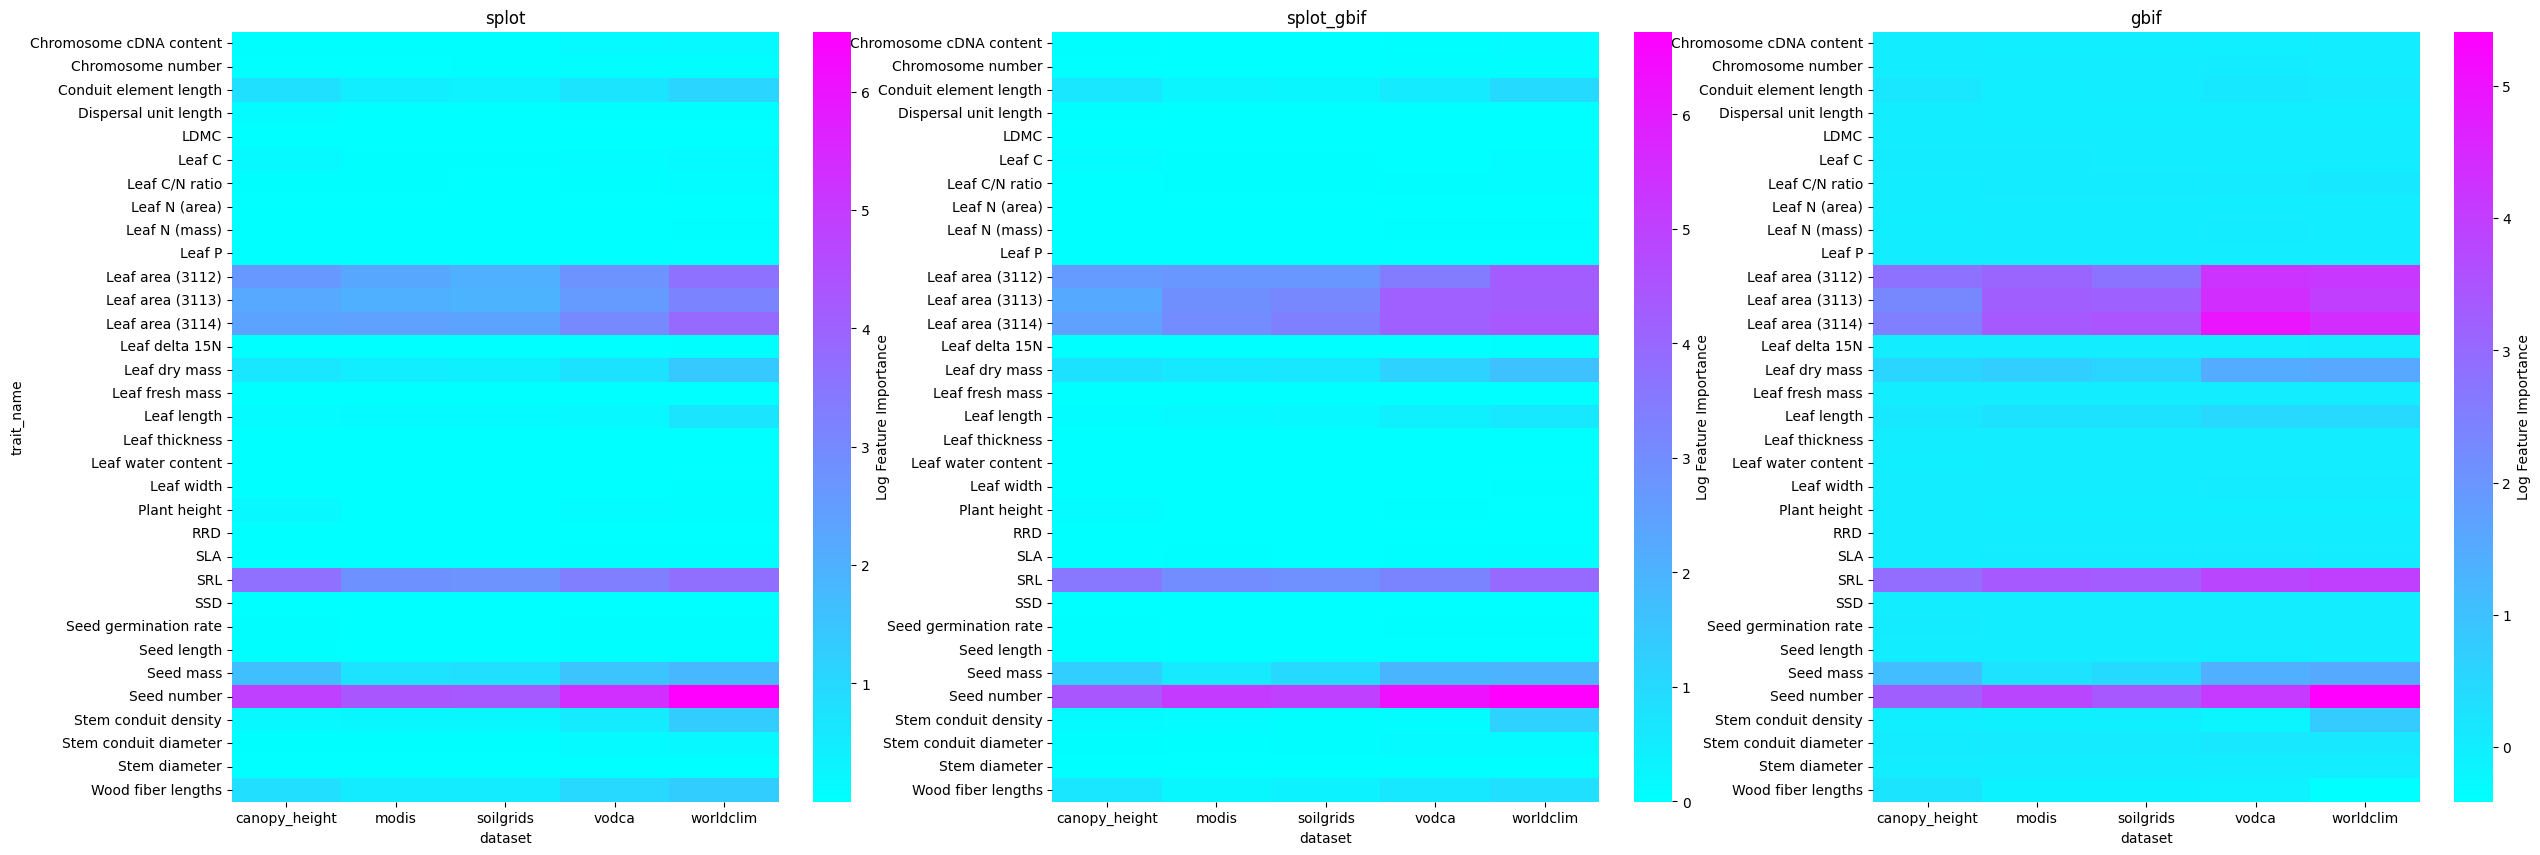

In [ ]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 10 * nrows))
for trait_set, ax in zip(trait_sets, axs.flatten()):
    # Plot a heatmap of the feature importance for each trait_id
    sns.heatmap(
        np.log1p(
            data.query(f"trait_set == '{trait_set}'").pivot(
                index="trait_name", columns="dataset", values="importance"
            )
        ),
        ax=ax,
        cmap="cool",
        cbar_kws={"label": "Log Feature Importance"},
    )

    ax.set_title(trait_set)

In [202]:
pca_data.pivot(columns="dataset", values="importance")

dataset,canopy_height,modis,soilgrids,vodca,worldclim
trait_id,,,,,
X1080_mean,3.579498,3.011828,2.943326,3.241115,3.964882
X11_mean,0.155401,0.171370,0.164368,0.189968,0.209116
X145_mean,0.163115,0.152863,0.153251,0.165611,0.182961
X15_mean,0.147701,0.148835,0.148607,0.149472,0.151857
X169_mean,0.267253,0.245795,0.195273,0.221984,1.233282
X18_mean,0.250602,0.148878,0.149341,0.173295,0.164663
X27_mean,0.173595,0.148990,0.149037,0.156412,0.164077
X281_mean,0.198509,0.188299,0.191150,0.264995,0.271581
X3112_mean,2.679154,2.758472,2.751932,3.458402,4.295874


In [266]:
pca_data

dataset,canopy_height,modis,soilgrids,vodca,worldclim
trait_id,,,,,
X1080_mean,3.579498,3.011828,2.943326,3.241115,3.964882
X11_mean,0.155401,0.171370,0.164368,0.189968,0.209116
X145_mean,0.163115,0.152863,0.153251,0.165611,0.182961
X15_mean,0.147701,0.148835,0.148607,0.149472,0.151857
X169_mean,0.267253,0.245795,0.195273,0.221984,1.233282
X18_mean,0.250602,0.148878,0.149341,0.173295,0.164663
X27_mean,0.173595,0.148990,0.149037,0.156412,0.164077
X281_mean,0.198509,0.188299,0.191150,0.264995,0.271581
X3112_mean,2.679154,2.758472,2.751932,3.458402,4.295874


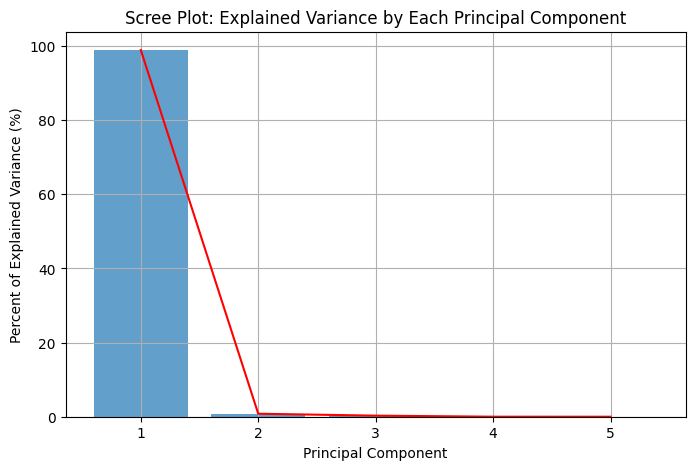

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df is your dataset, and 'trait_id' is not included in features
pca_data = data.query("trait_set == 'splot_gbif'")[
    ["trait_id", "importance", "dataset"]
].pivot(index="trait_id", columns="dataset", values="importance")
X = pca_data.reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# TODO: Compute means for each row and STD should be 1

# Apply PCA without specifying the number of components
pca = PCA()
pca.fit(X_scaled)

# Get explained variance ratios for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a scree plot for the explained variance of each component
plt.figure(figsize=(8, 5))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio * 100,
    alpha=0.7,
)
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio * 100,
    # s=50,
    c="red",
    label="Explained Variance (%)",
)
plt.xlabel("Principal Component")
plt.ylabel("Percent of Explained Variance (%)")
plt.title("Scree Plot: Explained Variance by Each Principal Component")
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

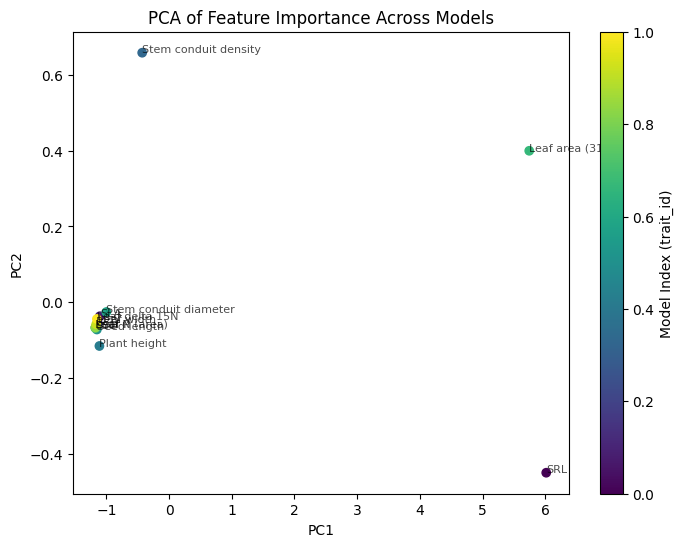

In [ ]:
trait_ids = pca_data.index

# Drop the trait_id column and apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data.reset_index(drop=True))

# Scatter plot of the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=np.linspace(0, 1, len(pca_data)),
    cmap="viridis",
)
plt.colorbar(label="Model Index (trait_id)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Feature Importance Across Models")

for i, trait_id in enumerate(trait_ids):
    plt.annotate(
        get_trait_name_from_id(trait_id)[0],
        (pca_result[i, 0], pca_result[i, 1]),
        fontsize=8,
        alpha=0.7,
    )

plt.show()

Text(0, 0.5, 'Contribution to PC3')

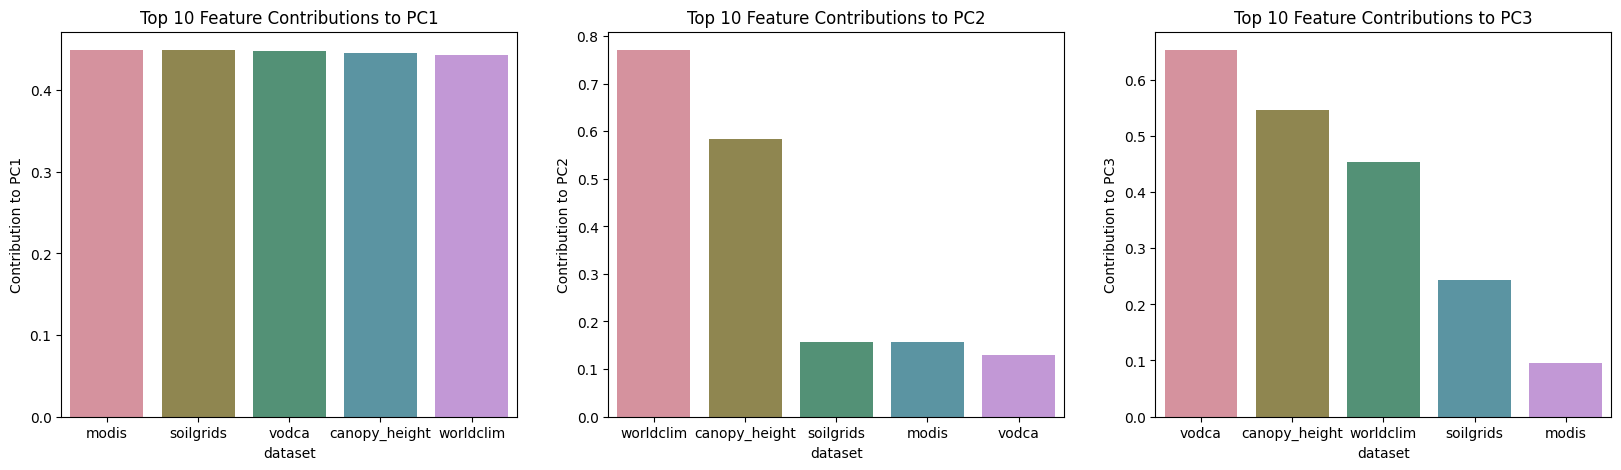

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume df has 150 features and 1 'trait_id' column
X = pca_data.reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=3)
pca.fit(X_scaled)

# Get the loadings (contribution of each feature to PC1 and PC2)
loadings = pd.DataFrame(
    pca.components_.T, columns=["PC1", "PC2", "PC3"], index=X.columns
)

# Sort loadings by absolute value to show the top contributing features for PC1
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(150)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(150)
top_pc3 = loadings["PC3"].abs().sort_values(ascending=False).head(150)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
# Bar plot for PC1
sns.barplot(
    x=top_pc1.index,
    y=top_pc1.values,
    ax=axs[0],
    hue=top_pc1.index,
    palette="husl",
    saturation=0.5,
)
axs[0].set_title("Top 10 Feature Contributions to PC1")
axs[0].set_ylabel("Contribution to PC1")

# Bar plot for PC2
sns.barplot(
    x=top_pc2.index,
    y=top_pc2.values,
    ax=axs[1],
    hue=top_pc2.index,
    palette="husl",
    saturation=0.5,
)
axs[1].set_title("Top 10 Feature Contributions to PC2")
axs[1].set_ylabel("Contribution to PC2")

# Bar plot for PC3
sns.barplot(
    x=top_pc3.index,
    y=top_pc3.values,
    ax=axs[2],
    hue=top_pc3.index,
    palette="husl",
    saturation=0.5,
)
axs[2].set_title("Top 10 Feature Contributions to PC3")
axs[2].set_ylabel("Contribution to PC3")

## OLD


In [45]:
# Shift fi_comb_mn_imp to avoid negatives and then take natural log
fi_comb_mn_imp_shifted = fi_comb_mn_imp + abs(fi_comb_mn_imp.min()) + 1
fi_comb_mn_imp_log = np.log(fi_comb_mn_imp_shifted)

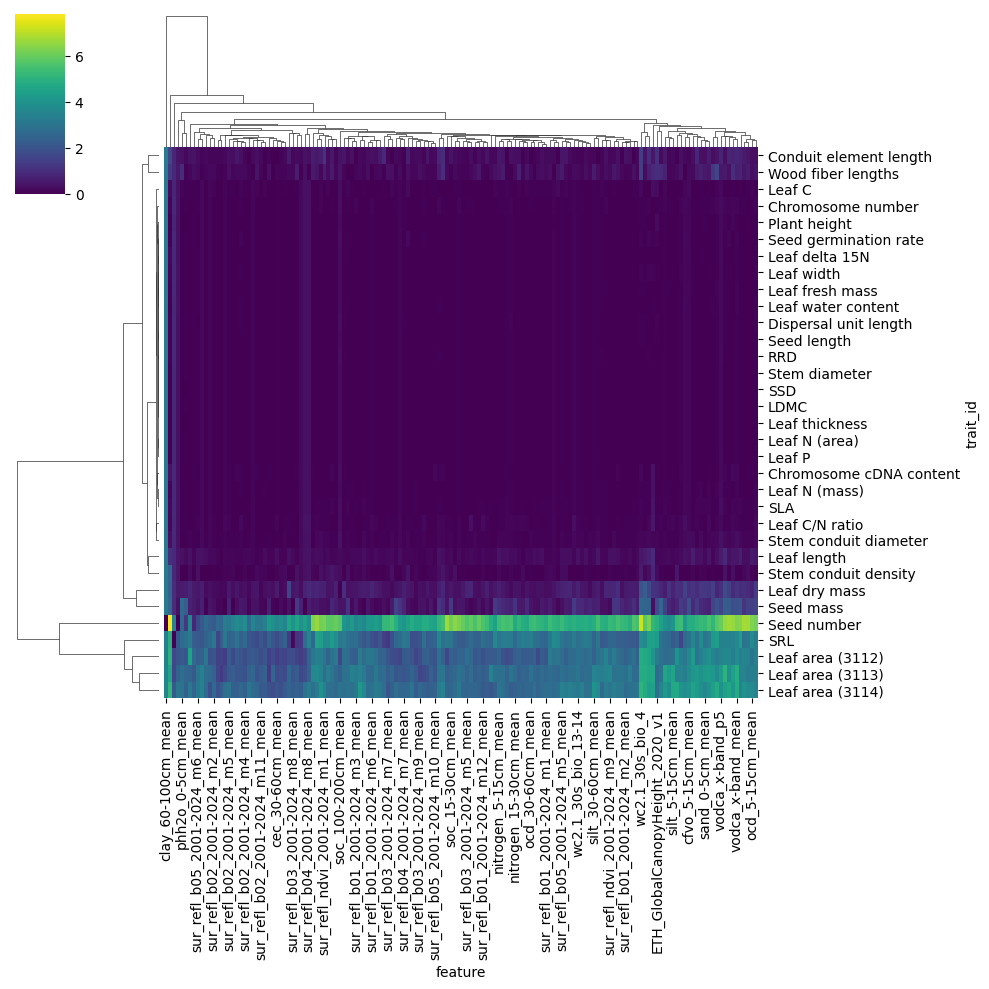

In [46]:
sns.clustermap(
    fi_comb_mn_imp_log,
    cmap="viridis",
    method="average",
    metric="euclidean",
    # figsize=(20, 20),
)

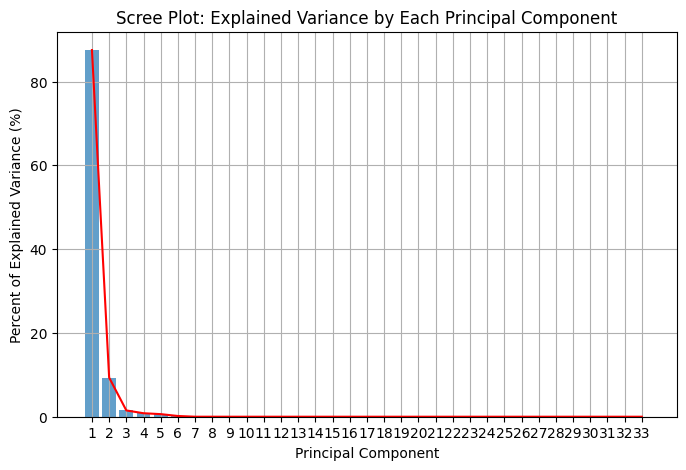

In [71]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df is your dataset, and 'trait_id' is not included in features
X = fi_comb_mn_imp.reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA without specifying the number of components
pca = PCA()
pca.fit(X_scaled)

# Get explained variance ratios for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a scree plot for the explained variance of each component
plt.figure(figsize=(8, 5))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio * 100,
    alpha=0.7,
)
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio * 100,
    # s=50,
    c="red",
    label="Explained Variance (%)",
)
plt.xlabel("Principal Component")
plt.ylabel("Percent of Explained Variance (%)")
plt.title("Scree Plot: Explained Variance by Each Principal Component")
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

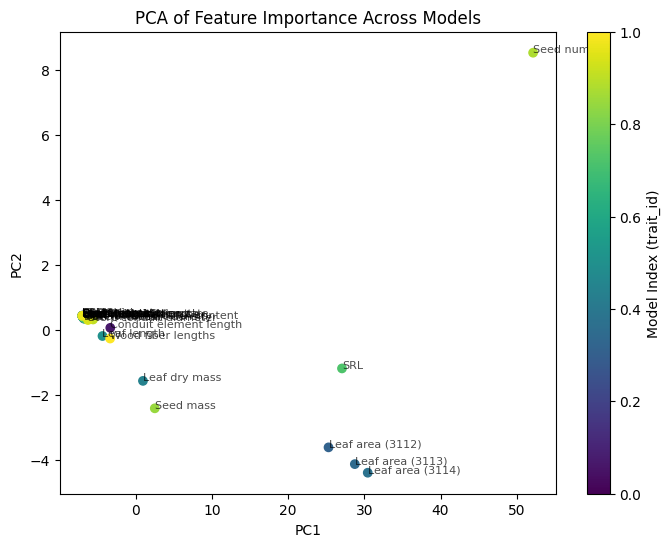

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

trait_ids = fi_comb_mn_imp_log.index

# Drop the trait_id column and apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(fi_comb_mn_imp_log.reset_index(drop=True))

# Scatter plot of the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=np.linspace(0, 1, len(fi_comb_mn_imp_log)),
    cmap="viridis",
)
plt.colorbar(label="Model Index (trait_id)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Feature Importance Across Models")

for i, trait_id in enumerate(trait_ids):
    plt.annotate(trait_id, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.7)

plt.show()

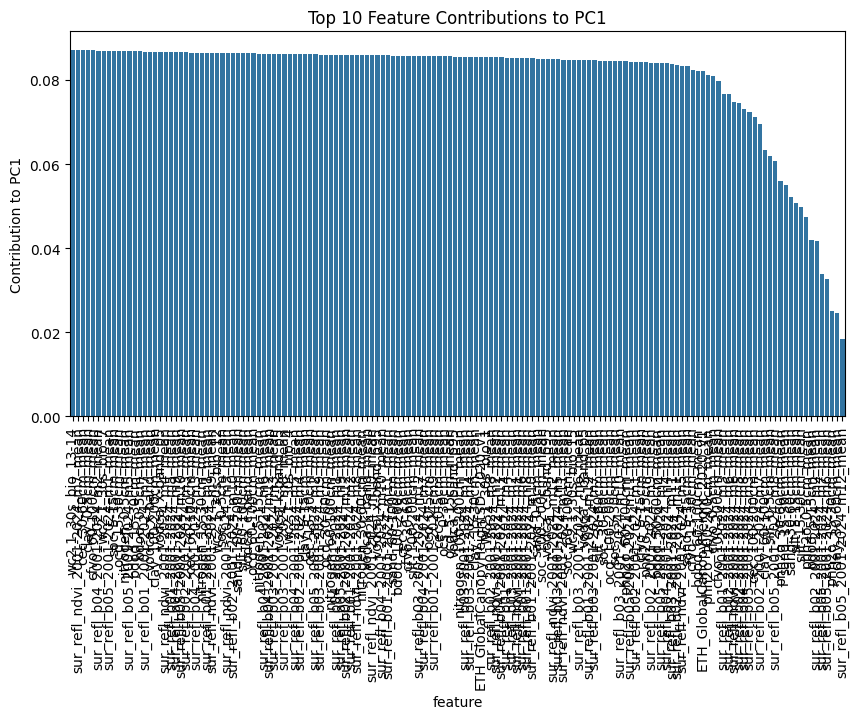

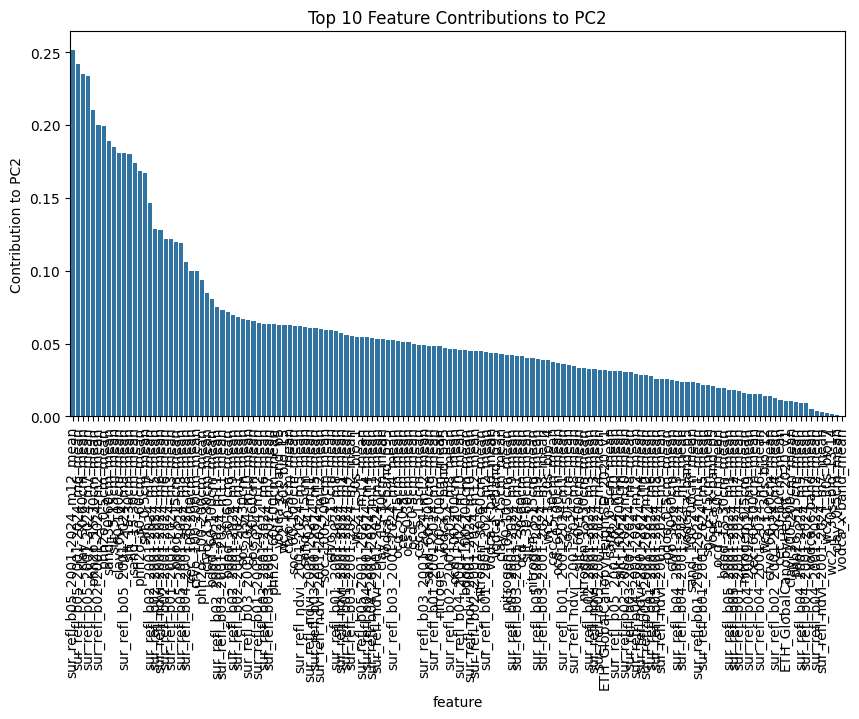

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume df has 150 features and 1 'trait_id' column
X = fi_comb_mn_imp.reset_index(drop=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Get the loadings (contribution of each feature to PC1 and PC2)
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"], index=X.columns)

# Sort loadings by absolute value to show the top contributing features for PC1
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(150)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(150)

# Bar plot for PC1
plt.figure(figsize=(10, 5))
sns.barplot(x=top_pc1.index, y=top_pc1.values)
plt.title("Top 10 Feature Contributions to PC1")
plt.xticks(rotation=90)
plt.ylabel("Contribution to PC1")
plt.show()

# Bar plot for PC2
plt.figure(figsize=(10, 5))
sns.barplot(x=top_pc2.index, y=top_pc2.values)
plt.title("Top 10 Feature Contributions to PC2")
plt.xticks(rotation=90)
plt.ylabel("Contribution to PC2")
plt.show()

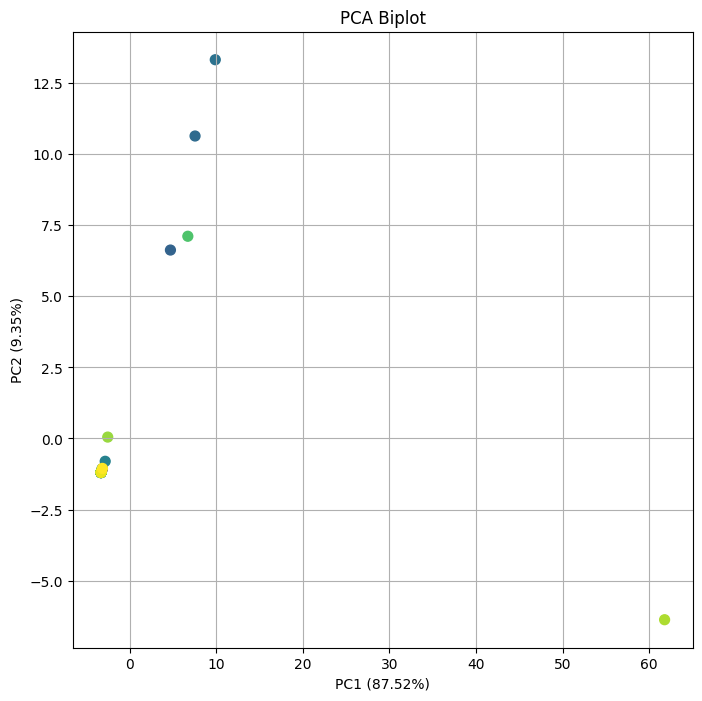

In [ ]:
import numpy as np


# Function to create a biplot
def biplot(pca_model, scaled_data, labels, top_features=10):
    scores = pca_model.transform(scaled_data)  # PCA scores (PC1 and PC2)
    loadings = pca_model.components_.T * np.sqrt(
        pca_model.explained_variance_
    )  # Loadings for features

    plt.figure(figsize=(8, 8))

    # Scatter plot of scores (the actual samples in PC1 and PC2 space)
    plt.scatter(
        scores[:, 0],
        scores[:, 1],
        c=np.linspace(0, 1, len(scores)),
        cmap="viridis",
        s=50,
    )
    plt.xlabel(f"PC1 ({pca_model.explained_variance_ratio_[0] * 100:.2f}%)")
    plt.ylabel(f"PC2 ({pca_model.explained_variance_ratio_[1] * 100:.2f}%)")

    # Add loading vectors (feature contributions)
    # for i, feature in enumerate(labels):
    #     plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color="r", alpha=0.5)
    # plt.text(
    #     loadings[i, 0] * 1.1,
    #     loadings[i, 1] * 1.1,
    #     feature,
    #     color="g",
    #     ha="center",
    #     va="center",
    # )

    plt.grid()
    plt.title("PCA Biplot")
    plt.show()


# Call the function for biplot
biplot(pca, X_scaled, X.columns)

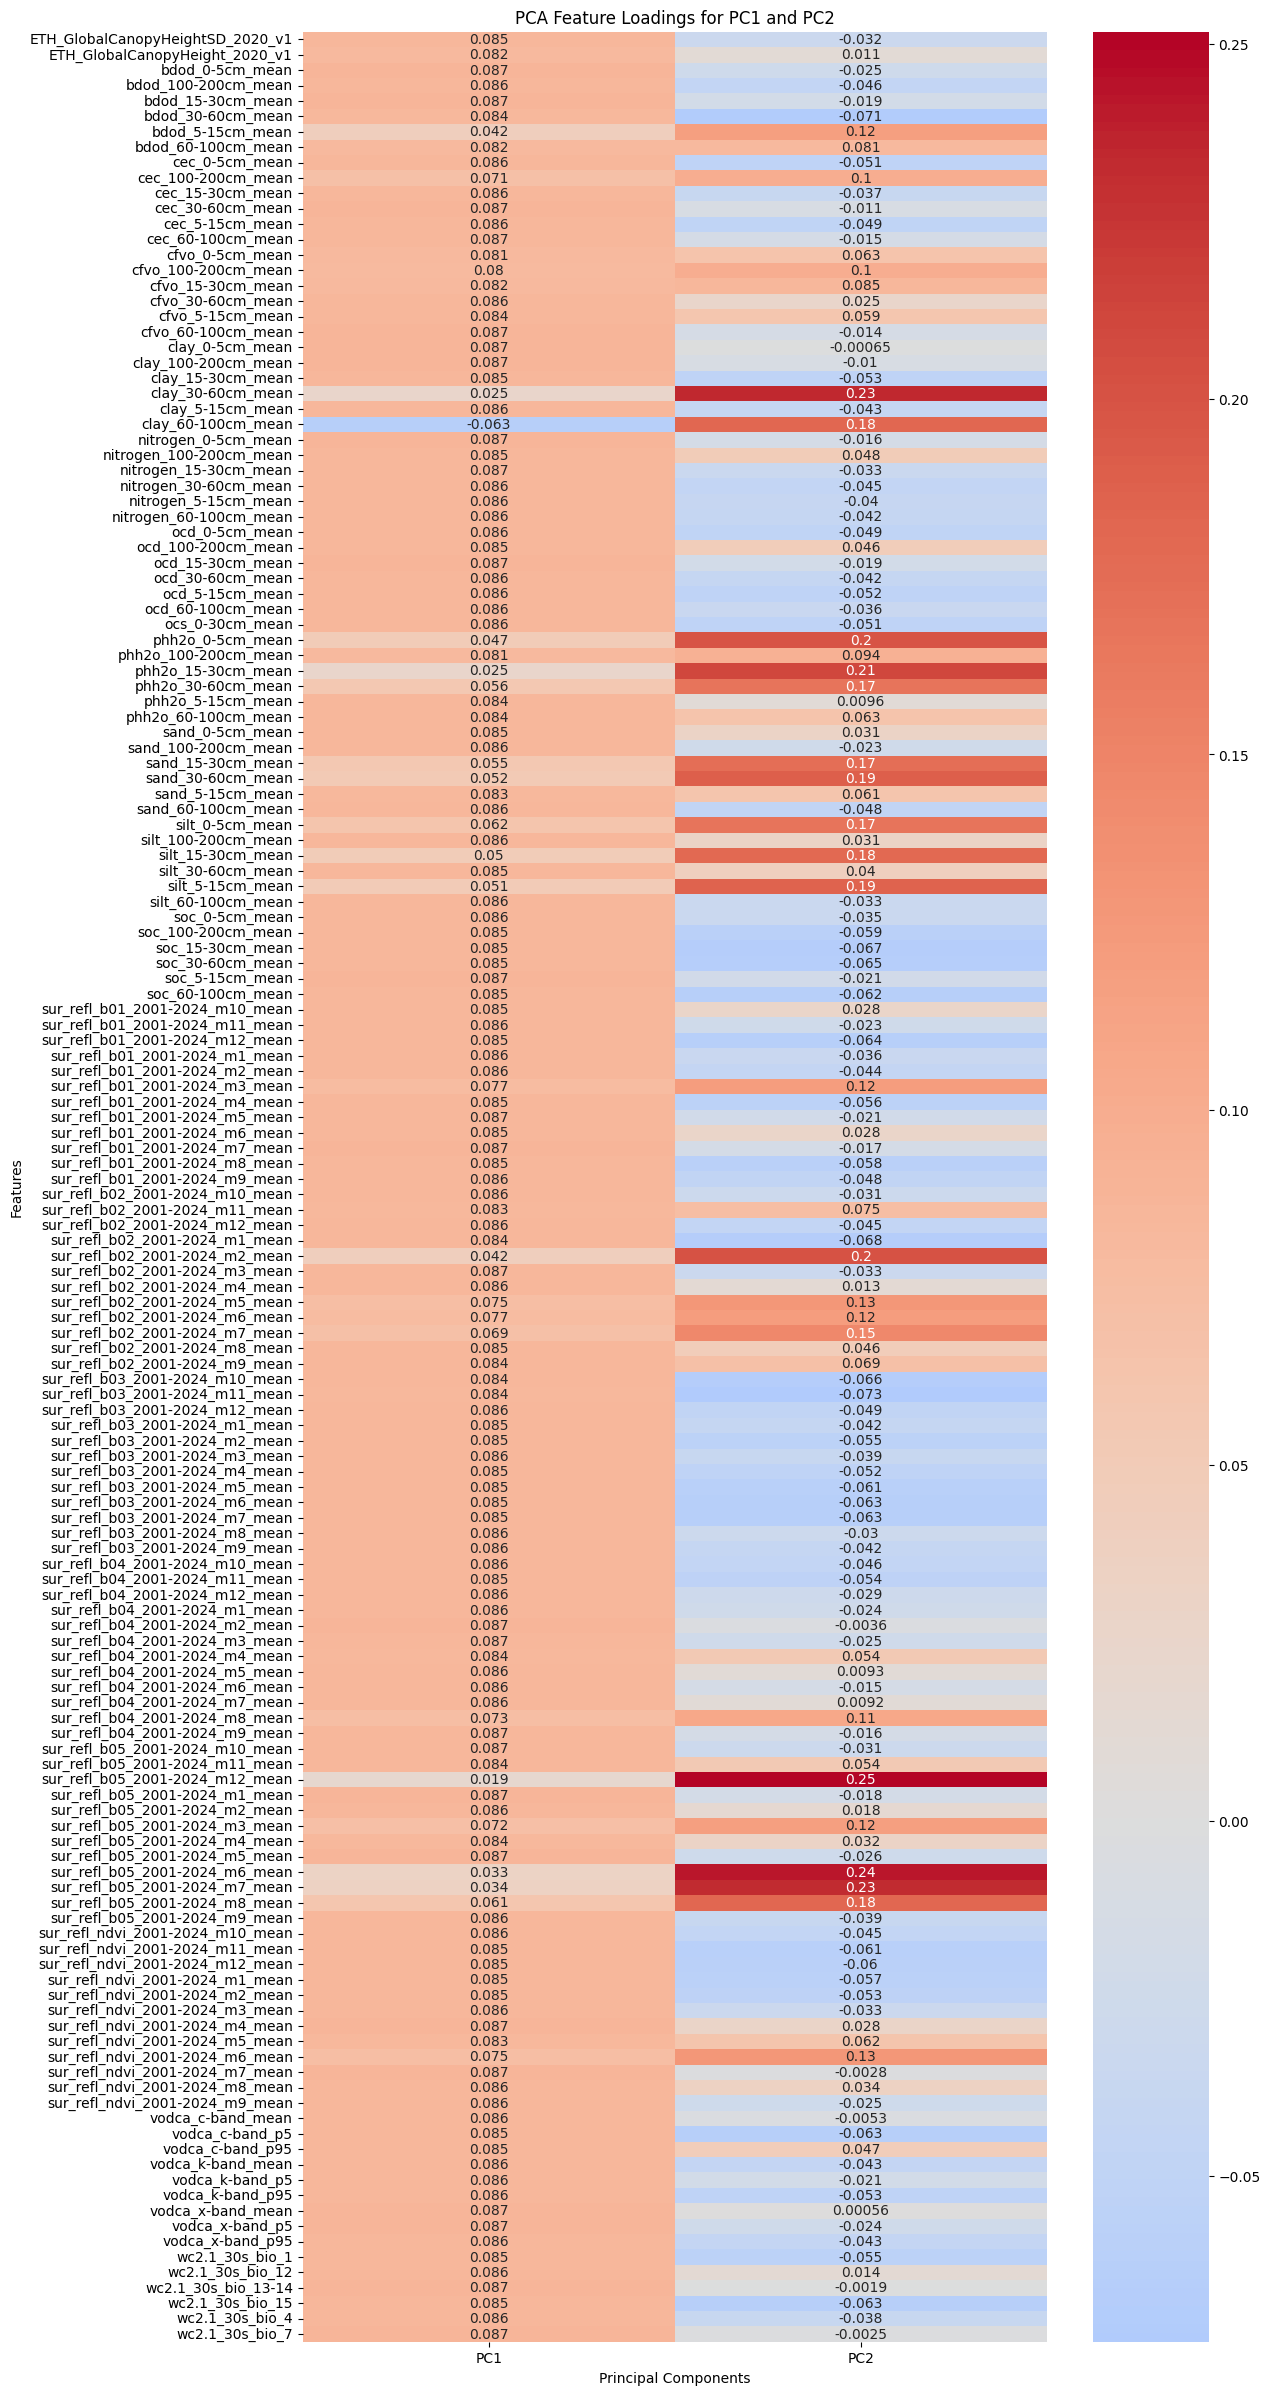

In [62]:
# Create a heatmap of loadings for the first two components
plt.figure(figsize=(12, 30))
sns.heatmap(loadings[["PC1", "PC2"]], annot=True, cmap="coolwarm", center=0)
plt.title("PCA Feature Loadings for PC1 and PC2")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()

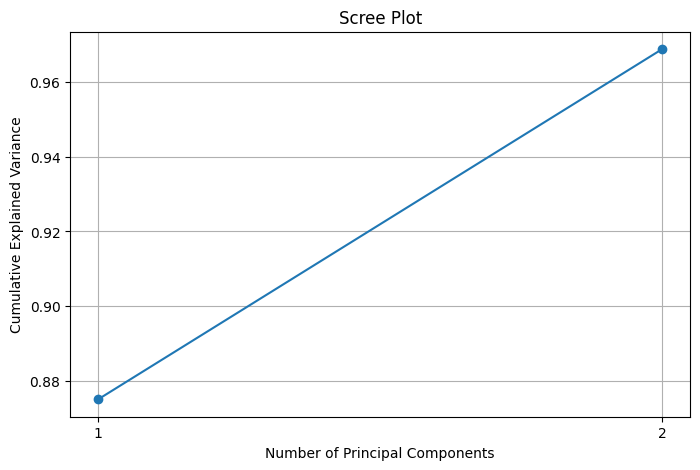

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

## Area of Applicability
